The dataset [[1]](#bib_cell) we will look at in this notebook aims to create just this predictive ability.  In particular it contains around 12,000 patient records containing a number of features about each patient, as well as whether or not a patient returned to the hospital within 30 days.
Our goal will be to use ML algorithms to try to predict which patients will in fact return within 30 days.

In [1]:
#Importing Python libraries
import numpy as np
import pandas as pd
import seaborn as sns


# Reading in the input dataset
medical_data = pd.DataFrame(pd.read_csv("balanced_cleaned_diabetes_data.csv"))

In [2]:
#Looking at the dataset

medical_data.head()

,age,gender,number_emergency,readmitted
0,[70-80),Female,0,NO
1,[50-60),Male,0,>30
2,[60-70),Male,0,>30
3,[70-80),Female,0,<30
4,[70-80),Male,0,NO


In [3]:
#Exploring the columns of the dataset
#Total number of rows and columns of the dataset

print("This dataset has {} rows and {} columns".format(medical_data.shape[0], medical_data.shape[1]))

#Age
import re
print('The following are the age groups in this sample: '+ '\n')
for age_group in medical_data['age'].unique():
    age_groups = re.findall(r'\d+', str(age_group))
    print('{} to {}'.format(age_groups[0], age_groups[1]))
    
#Unique number of emergencies

medical_data['number_emergency'].nunique()


    


This dataset has 15628 rows and 4 columns
The following are the age groups in this sample: 

70 to 80
50 to 60
60 to 70
0 to 10
40 to 50
80 to 90
90 to 100
30 to 40
20 to 30
10 to 20


23

**1.**  The columns here are the input - or 'features' - of the dataset are:

**gender** - gender of patient

**age** - age of patient, split into 10 year chunks

**number_emergency** - Number of emergency visits of the patient in the year preceding the encounter

**2.**  The target / labels are:

**readmitted** - consists of "> 30" (readmitted within 30 days), "< 30" (readmitted after 30 days), and NO (no history of readmission)

In [4]:
#Pre-processing input data

#Transforming the age column while preserving ordinality
age_groups = {'[0-10)': 1,'[10-20)': 2, '[20-30)':3, '[30-40)': 4, '[40-50)':5, '[50-60)':6,'[60-70)':7 ,'[70-80)':8,'[80-90)':9,'[90-100)':10}

medical_data['age'] = medical_data['age'].map(age_groups)



In [5]:
# Converting female, male into binary values

medical_data ['gender'] = medical_data['gender'].map({'Female': 0, 'Male': 1})

#Converting values of output variables 

medical_data['readmitted'] = medical_data['readmitted'].map({'>30': 0, 'NO' : 0, '<30': 1})

#Now the input medical data has been transformed

In [6]:
#Fitting a simple logistic regression model

input_data_1 = medical_data[['gender','age','number_emergency']]
labels_1 = medical_data['readmitted']


null_columns=input_data_1.columns[input_data_1.isnull().any()]





In [7]:
# create the linear logistic regression classifier and plug it into the previous Python function
from sklearn.metrics import accuracy_score   # an accuracy scoring function from scikit learn
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# fit our chosen classifier to the dataset
classifier.fit(input_data_1, labels_1)                              

# print out the number of misclassified points
predicted_labels = classifier.predict(input_data_1)

classifier.score(input_data_1, labels_1)

0.56968262093678013

Since the accuracy of the simple logistic regression classifier is very low, can compare the cross validation errors of more complex models on this dataset to figure out the best model to be used

RF: 0.259778 (0.099073)
LG: 0.217867 (0.114982)


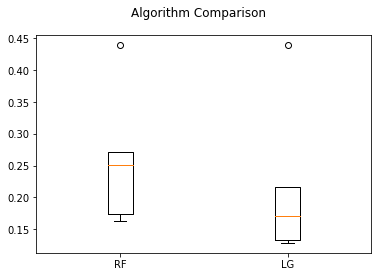

In [8]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import matplotlib.pyplot as plt
seed = 7
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LG', LogisticRegression()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, input_data_1, labels_1, cv = kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

     # Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



In [9]:
#GridSearchCV for hyperparameter optimization

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data_1,labels_1, test_size = 0.2, random_state = 42)

classifier = RandomForestClassifier()

# range of parameters to test with cross-validation
parameters = {'max_depth': np.arange(10,20), 'n_estimators': np.arange(10,100,10)}

# create an instance of the GridSearchCV cross-validator - using our classifier and choice or parameters
cross_validator = GridSearchCV(classifier, parameters, cv=5, n_jobs=-1, verbose= 1,scoring="accuracy")

# get the best parameter choice based on cross-validation and print out
cross_validator.fit(X_train,y_train)        
best_param =  cross_validator.best_estimator_.max_depth     
print 'best parameter according to cross-validation param is = ' + str(best_param)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.2min finished


best parameter according to cross-validation param is = 11


In [10]:
#Finally getting the accuracy of the optimized model on the test data

from sklearn import metrics

best_model = cross_validator.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)

print("The accuracy of the model on the test set is {}".format(accuracy))

The accuracy of the model on the test set is 0.579014715291


We see a marginal improvement in the accuracy resulting from the cross validated tree model